In [1]:
# Imports
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

/transformers/src/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# Define the working device
device = torch.device("cuda")

In [4]:
import pandas as pd

datasets = pd.read_csv("/storage1/fs1/yeli/Active/l.ronghan/data/humanbrain_cCREs/nt_data/subclass/extended_humanbrain_cCREs_subclass.csv")
missing_values = datasets.isna().sum()
print(missing_values)
datasets.head()

cell     0
chr      0
start    0
end      0
seq      0
dtype: int64


,cell,chr,start,end,seq
0,ASCT,chr1,2320885,2323884,GGTTGGCTGGCCGGGCTTCACTGCAGAGCTCTGCGGCAGGGAGACA...
1,ASCT,chr1,6271959,6274958,CTGCAGGCACGGAGTGCCGTGGTCCCGGGACGCTCGGCTCACAGCT...
2,ASCT,chr1,18479335,18482334,CAGACACAGCCTTTTACCCAACTCTGATGGGCCAGAGGGATGTCCA...
3,ASCT,chr1,20785211,20788210,TTAAATTATTTGAATGCAAGCAATAAAAAAAAGTATTGTAGAAATA...
4,ASCT,chr1,26992130,26995129,CCTCCACCAAGAGGACTAGACCCAGGTATCTGAGCCCCCAGAGGGC...


In [5]:
cell_types = datasets['cell'].unique()
print(len(cell_types))
num_labels = len(cell_types)
cell_type_to_index = {cell_type: index for index, cell_type in enumerate(cell_types)}
datasets['label'] = datasets['cell'].map(cell_type_to_index)
datasets.head()

6


,cell,chr,start,end,seq,label
0,ASCT,chr1,2320885,2323884,GGTTGGCTGGCCGGGCTTCACTGCAGAGCTCTGCGGCAGGGAGACA...,0
1,ASCT,chr1,6271959,6274958,CTGCAGGCACGGAGTGCCGTGGTCCCGGGACGCTCGGCTCACAGCT...,0
2,ASCT,chr1,18479335,18482334,CAGACACAGCCTTTTACCCAACTCTGATGGGCCAGAGGGATGTCCA...,0
3,ASCT,chr1,20785211,20788210,TTAAATTATTTGAATGCAAGCAATAAAAAAAAGTATTGTAGAAATA...,0
4,ASCT,chr1,26992130,26995129,CCTCCACCAAGAGGACTAGACCCAGGTATCTGAGCCCCCAGAGGGC...,0


In [6]:
print("label min:", datasets['label'].min())
print("label max:", datasets['label'].max())
print("num of labels:", num_labels)

label min: 0
label max: 5
num of labels: 6


In [7]:
train_data, temp_data = train_test_split(datasets, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [8]:
# Get training data
train_sequences = train_data['seq']
train_labels = train_data['label']
train_sequences

642     TCTATCTTGATGTGTGTGAATCAGAAACTGAACATTCCAGCCAGGT...
700     CACCGGAGAAATTGTAGTTTCAGAAAGGGCTAGATGACCTGTCGTT...
226     TTTTAAAAAAAGTTTTTAAAAAAGGAAACAAACATTGCACACGAGT...
1697    CCATCTGGCAGGGACTGTGCCTAATTTTTCTTATTAATTGCTGAGT...
1010    AGAAGAGCTTTAAATACTGTATCCATGTAACATTCTTATAATGTAC...
                              ...                        
1638    CCTGAATAATTTGAACTCTTATTTAGGAAAAAAATGTTTTTTCACC...
1095    GCGTGAGCCACCATGCCCTGCCAAGAGTTAGGTATTCCTTACAGTC...
1130    TTTAATCTAAAAACACAGCAATATTGTCCTAATTTATGGAAAACAT...
1294    TTACAGCTGAGGGAGATGCAAGAGAAGTCTGGGTCACACACCACAG...
860     TGTGTTTACTAATGGATCGAGGCCTCTTGGGTTTTTCTAATTGACT...
Name: seq, Length: 2400, dtype: object

In [9]:
# Get val/testing data
valid_sequences = valid_data['seq']
valid_labels = valid_data['label']

test_sequences = test_data['seq']
test_labels = test_data['label']

In [10]:
idx_sequence = 1
sequence, label = train_sequences[idx_sequence], train_labels[idx_sequence]
print(f"The DNA sequence is {sequence}.")
print(f"Its associated label is label {label}.")

The DNA sequence is CTGCAGGCACGGAGTGCCGTGGTCCCGGGACGCTCGGCTCACAGCTCTTGTGCCGGAGTGTGGACATGGCGGTCCCCACCCTACAACACCAATAATGATCATAGCTGTCACCTGCTGAGTGCCCACTGTGGGCTAGGCCTGGGCCAGAAGCCGCGTGCTCATGGCACACCTCTGCTGTGCGTGTGCCCACTCTGTGCTATGCCCTGTGGAGCCCTTCCTGTCCTGCTGGAGGCCAGCACCATGCCTGGACATAGCAGGGGCACAGGAGGTGTTTGCTGGATGGATGAATGAATGAATGAATGAATGATCAAACAAATGAAGATCAAAAAGGCTTAATTCTAAATAGGGATGGTCTTTATGTTAACAATTCAAAACCAGTACTTCTGCTCAATGAACACTGGCATCATCTGTCCCCAATCAATTCCAGGGGGCTCAGACCATGGAGGGTCTGAACAGGAGCCTGCAACAGTGACAAAGATGAGATGAGAGTGTCCAGCACACCTAGGCTTGGCCATCCCCCTGGAGATGGGCCAGCTCTGTGGCCATGCTGGGGACTTGCTTCTGATCCTGCACACACAGGTGGGGAGGGCTCTGCATCCTTTCTACCACCGTGTGGGGCACAGGGCCTGTTTCTTCCTGCACCTTTGCTTGCAGGGCTCAAGATGTGTGTCTGGCCGCAAAGAGCCTTTGCCAGGACACTCCACACCCCTTGCTGAGAGCGCCGAGCCAAGTGGGCGGCCTCCAGCCCCAGGATACTCCAGGCATGAACTCGCCCTGCTGAAAAACTCCAAGTCCCATGGCCAGGACCTCACATGGGCCCAACAACCTTTCCAGGCCTCCCTGACAGATCTCTCGCTCACCTTCCGCAGCACCCTGGGTCTAGCCGGGATGCTCCCTCGGTTCACTGAATCCTCTGGAAATCCCACCCACGGGCCTCTCCTGGTACAGCCCCCCTCCTGGCAGTGCTCACTCTGTCCGTG

In [24]:
num_labels = num_labels
# Load the model
model = AutoModelForSequenceClassification.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species", num_labels=num_labels)
model = model.to(device)


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

The repository for InstaDeepAI/nucleotide-transformer-v2-50m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


esm_config.py:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


The repository for InstaDeepAI/nucleotide-transformer-v2-50m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


modeling_esm.py:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-50m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-50m-multi-species and are newly initialized: ['classifier.dense.bias', 'c

In [25]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species")

tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

In [26]:
# Promoter dataset
from datasets import load_dataset, Dataset

ds_train = Dataset.from_dict({"data": train_sequences,'labels':train_labels})
ds_valid = Dataset.from_dict({"data": valid_sequences,'labels':valid_labels})
ds_test = Dataset.from_dict({"data": test_sequences,'labels':test_labels})


In [27]:
def tokenize_function(examples):
    outputs = tokenizer(examples["data"])
    return outputs


In [28]:
# Creating tokenized promoter dataset
tokenized_datasets_train = ds_train.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_valid = ds_valid.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_test = ds_test.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [29]:
len(train_sequences)

2400

In [30]:
batch_size = 2
model_name='humanbrain-extended'
args_promoter = TrainingArguments(
    f"{model_name}-finetuned-NucleotideTransformer",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size= 32,
    num_train_epochs= 2,
    logging_steps= 10,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="f1_score",
    label_names=["labels"],
    dataloader_drop_last=True,
    max_steps= 100
)

/transformers/src/transformers/training_args.py:1541: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [31]:
# Define the metric for the evaluation using the f1 score
def compute_metrics_f1_score(eval_pred):
    """Computes F1 score for binary classification"""
    predictions = np.argmax(eval_pred.predictions, axis=-1)
    references = eval_pred.label_ids
    r={'f1_score': f1_score(references, predictions)}
    return r

In [32]:
trainer = Trainer(
    model.to(device),
    args_promoter,
    train_dataset= tokenized_datasets_train,
    eval_dataset= tokenized_datasets_valid,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_f1_score,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
max_steps is given, it will override any value given in num_train_epochs
CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.


In [33]:
torch.cuda.empty_cache()
train_results = trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 31.73 GiB of which 6.69 MiB is free. Process 1796423 has 23.44 GiB memory in use. Process 1826306 has 8.28 GiB memory in use. Of the allocated memory 7.70 GiB is allocated by PyTorch, and 213.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# PCA

In [2]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
import numpy as np
import pandas as pd
import sys

# Import the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species", trust_remote_code=True)
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species", trust_remote_code=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Choose the length to which the input sequences are padded
# max_length = tokenizer.model_max_length
max_length = 32

/transformers/src/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [3]:
# Define batch size
batch_size = 1  # Adjust this based on your GPU memory

def process_batch(sequences):
    # Tokenize sequences
    # tokens_ids = tokenizer.batch_encode_plus(sequences, return_tensors="pt", padding=True, truncation=True, max_length=max_length)["input_ids"]
    tokens_ids = tokenizer.batch_encode_plus(sequences, return_tensors="pt", padding="max_length", max_length = max_length)["input_ids"]

    # Move tensors to the same device as the model
    tokens_ids = tokens_ids.to(device)
    attention_mask = (tokens_ids != tokenizer.pad_token_id).to(device)
    
    # Compute embeddings
    torch_outs = model(
        tokens_ids,
        attention_mask=attention_mask,
        output_hidden_states=True
    )
    
    # Extract embeddings
    # embeddings = torch_outs['hidden_states'][-1]
    embeddings = torch_outs['hidden_states'][-1]
    attention_mask = attention_mask.unsqueeze(-1)
    
    # Compute mean embeddings per sequence
    # Move embeddings to the correct device
    embeddings = embeddings.to(device)
    mean_sequence_embeddings = torch.sum(attention_mask * embeddings, axis=-2) / torch.sum(attention_mask, axis=1)
    print(mean_sequence_embeddings.shape)
    
    return embeddings.detach().cpu().numpy(), mean_sequence_embeddings.detach().cpu().numpy()  # Move to CPU for further processing


In [4]:
df = pd.read_csv('/storage1/fs1/yeli/Active/l.ronghan/data/humanbrain_cCREs/nt_data/subclass/extended_humanbrain_cCREs_subclass.csv')
sequences = df['seq'].tolist()
print(f"Total number of sequences is: {len(sequences)}")

# Split sequences into batches and process each batch
embeddings_list=[]
mean_embeddings_list = []
for i in range(0, 2500, batch_size):
    batch_sequences = sequences[i:i + batch_size]
    print(f"Processing batch {i // batch_size + 1} out if {len(sequences)}")
    try:
        embeddings, batch_embeddings = process_batch(batch_sequences)
        # mean_embeddings_list.append(batch_embeddings)
        if batch_embeddings is not None:
            embeddings_list.append(embeddings)
            mean_embeddings_list.append(batch_embeddings)
            print(f"Batch {i // batch_size + 1} processed successfully.")
            
            # Clear the GPU cache only after successful processing
            torch.cuda.empty_cache()
        else:
            print(f"Batch {i // batch_size + 1} failed: No embeddings returned.")  
    except RuntimeError as e:
        print(f"Error processing batch {i // batch_size + 1}: {e}")
        break


Total number of sequences is: 3000
Processing batch 1 out if 3000
torch.Size([1, 512])
Batch 1 processed successfully.
Processing batch 2 out if 3000
torch.Size([1, 512])
Batch 2 processed successfully.
Processing batch 3 out if 3000
torch.Size([1, 512])
Batch 3 processed successfully.
Processing batch 4 out if 3000
torch.Size([1, 512])
Batch 4 processed successfully.
Processing batch 5 out if 3000
torch.Size([1, 512])
Batch 5 processed successfully.
Processing batch 6 out if 3000
torch.Size([1, 512])
Batch 6 processed successfully.
Processing batch 7 out if 3000
torch.Size([1, 512])
Batch 7 processed successfully.
Processing batch 8 out if 3000
torch.Size([1, 512])
Batch 8 processed successfully.
Processing batch 9 out if 3000
torch.Size([1, 512])
Batch 9 processed successfully.
Processing batch 10 out if 3000
torch.Size([1, 512])
Batch 10 processed successfully.
Processing batch 11 out if 3000
torch.Size([1, 512])
Batch 11 processed successfully.
Processing batch 12 out if 3000
torch

In [8]:
# # Concatenate all embeddings
# if embeddings_list:
#     all_embeddings = np.concatenate(embeddings_list, axis=0)
#     # Compute mean embeddings per sequence over the sequence length dimension (axis 1)
#     all_embeddings = np.mean(all_embeddings, axis=1)
#     print(f"All sequence embeddings shape: {all_embeddings.shape}")
    
#     # Create a DataFrame with the embeddings
#     embeddings_df = pd.DataFrame(all_embeddings)
    
#     # Save the DataFrame to a CSV file
#     output_file = sys.argv[1]
#     # output_file = '/storage1/fs1/yeli/Active/l.ronghan/projects/nt_unsupervised/output/mean_embeddings_400k.csv'
#     embeddings_df.to_csv(output_file, index=False)
    
#     print(f"Embeddings successfully saved to {output_file}")
# else:
#     print("No embeddings computed.")

if mean_embeddings_list:
    all_mean_embeddings = np.concatenate(mean_embeddings_list, axis=0)
    print(f"All mean sequence embeddings shape: {all_mean_embeddings.shape}")
    
    # Create a DataFrame with the embeddings
    mean_embeddings_df = pd.DataFrame(all_mean_embeddings)
    
    # Save the DataFrame to a CSV file
    # mean_output_file = sys.argv[2]
    mean_output_file = '/storage1/fs1/yeli/Active/l.ronghan/projects/4.nt_unsupervised/output/mean_embeddings_1111.csv'
    mean_embeddings_df.to_csv(mean_output_file, index=False)
    
    print(f"Embeddings successfully saved to {mean_output_file}")
else:
    print("No embeddings computed.")


All mean sequence embeddings shape: (2500, 512)
Embeddings successfully saved to /storage1/fs1/yeli/Active/l.ronghan/projects/4.nt_unsupervised/output/mean_embeddings_1111.csv


In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np


In [2]:
print("Loading sampled data and labels...")
embeddings_path = '/storage1/fs1/yeli/Active/l.ronghan/projects/4.nt_unsupervised/output/mean_embeddings_1111.csv'
labels_path = "/storage1/fs1/yeli/Active/l.ronghan/data/humanbrain_cCREs/nt_data/subclass/extended_humanbrain_cCREs_subclass.csv"

# embeddings_df = pd.read_csv(embeddings_path, skiprows=lambda x: x not in sample_indices)
embeddings_df = pd.read_csv(embeddings_path)

labels_df = pd.read_csv(labels_path, usecols=['cell'], nrows=2501)
print("Embeddings shape:", embeddings_df.shape)
print("Labels shape:", labels_df.shape)


Loading sampled data and labels...
Embeddings shape: (2500, 512)
Labels shape: (2501, 1)


In [3]:
labels_df

,cell
0,ASCT
1,ASCT
2,ASCT
3,ASCT
4,ASCT
...,...
2496,ITL23
2497,ITL23
2498,ITL23
2499,ITL23


Initializing 2D PCA...
Starting plot 2D PCA...


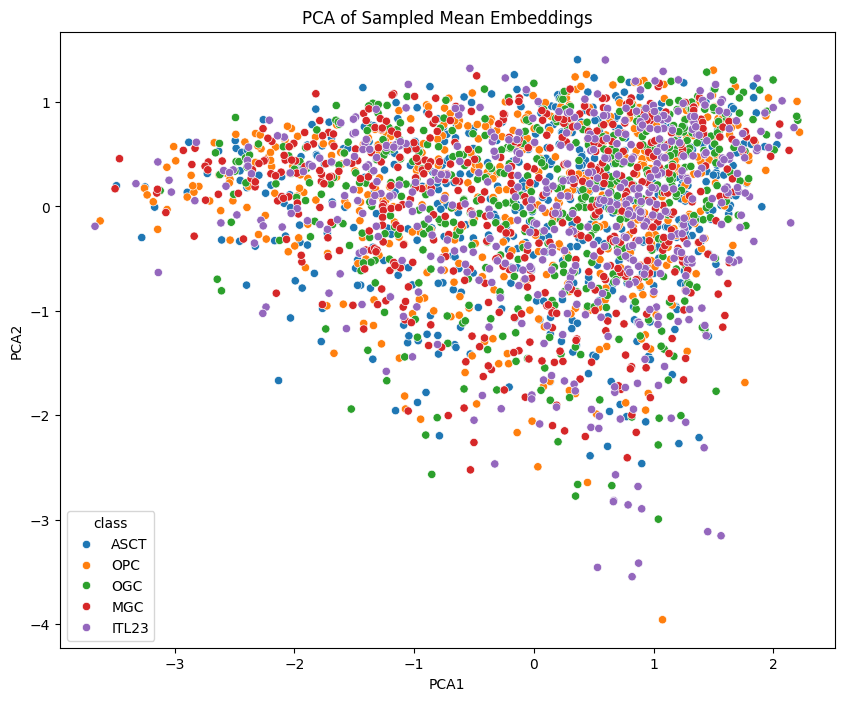

In [4]:
print("Initializing 2D PCA...")
ipca = IncrementalPCA(n_components=2, batch_size=1000)  
pca_result = ipca.fit_transform(embeddings_df)

# store PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['class'] = labels_df

# plot 2D PCA
print("Starting plot 2D PCA...")
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='class', data=pca_df, palette='tab10')
plt.title('PCA of Sampled Mean Embeddings')

plt.show()

In [5]:
plt.savefig('figures/pca_mean_embeddings_1111.png', dpi=300)

<Figure size 640x480 with 0 Axes>

Initializing 3D PCA...
Starting plot 3D PCA...


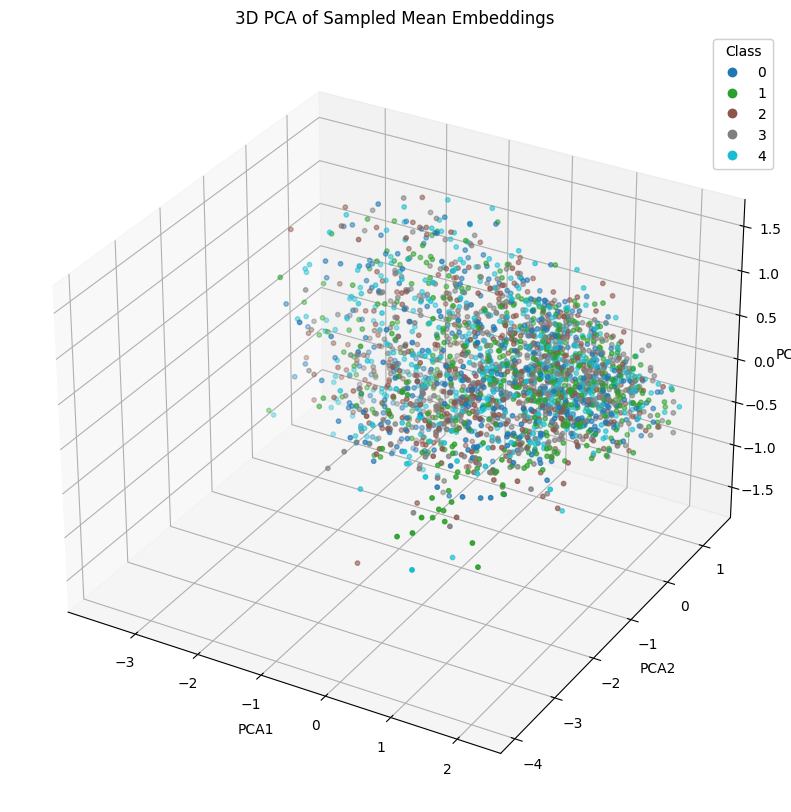

In [7]:
print("Initializing 3D PCA...")
ipca = IncrementalPCA(n_components=3, batch_size=1000)  
pca_result = ipca.fit_transform(embeddings_df)

# Store PCA results in a DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df['class'] = labels_df['cell']

# Plot 3D PCA
print("Starting plot 3D PCA...")
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA3'], c=pca_df['class'].astype('category').cat.codes, cmap='tab10', s=10, picker=True)

# Adding legend and labels
legend1 = ax.legend(*scatter.legend_elements(), title="Class")
ax.add_artist(legend1)
ax.set_title('3D PCA of Sampled Mean Embeddings')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.show()

Initializing 3D PCA...
Starting interactive 3D PCA plot...


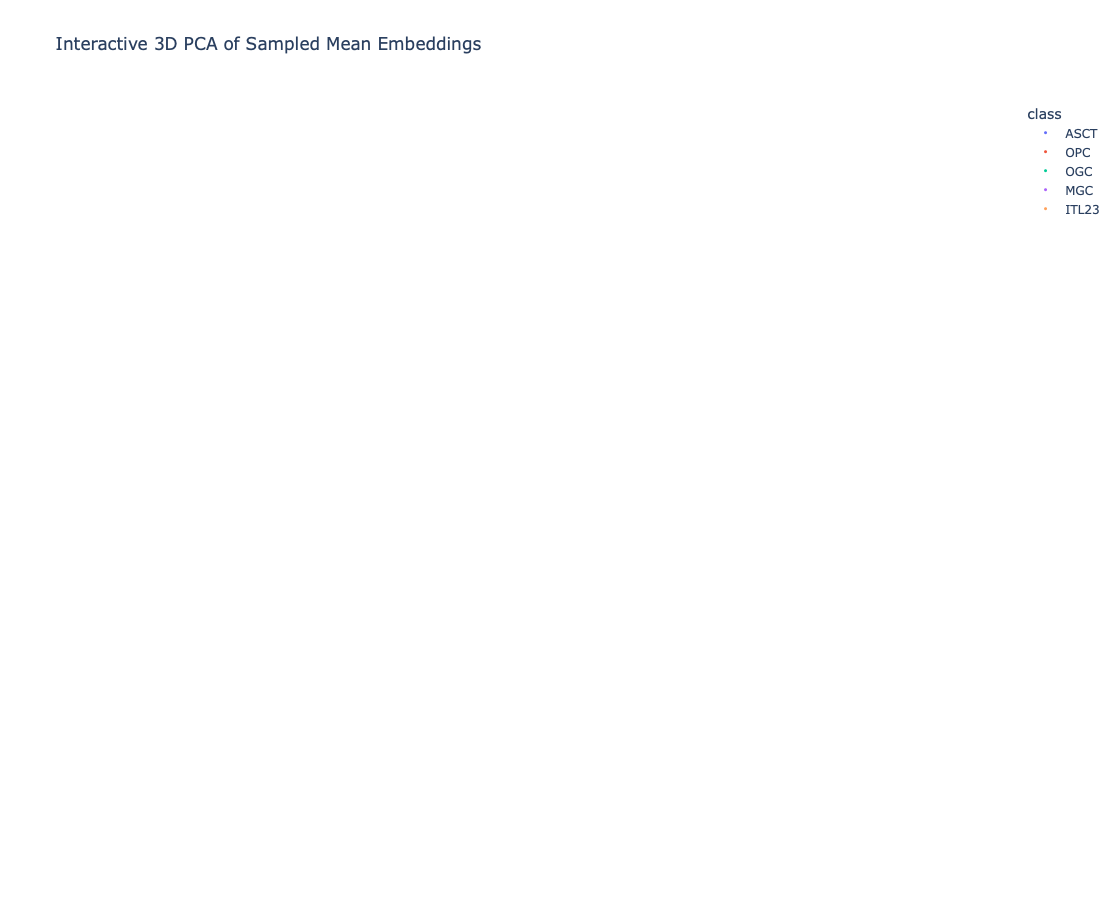

In [14]:
import pandas as pd
from sklearn.decomposition import IncrementalPCA
import plotly.express as px

print("Initializing 3D PCA...")
ipca = IncrementalPCA(n_components=3, batch_size=1000)  
pca_result = ipca.fit_transform(embeddings_df)

# Store PCA results in a DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df['class'] = labels_df['cell']

# Plot 3D PCA with plotly
print("Starting interactive 3D PCA plot...")
fig = px.scatter_3d(
    pca_df,
    x='PCA1', y='PCA2', z='PCA3',
    color='class',
    title='Interactive 3D PCA of Sampled Mean Embeddings',
    labels={'PCA1': 'PCA1', 'PCA2': 'PCA2', 'PCA3': 'PCA3'}
)

fig.update_traces(marker=dict(size=3 
                                
                男男女女·1111111111          1))
fig.update_layout(width=1000, height=900) 
fig.show()